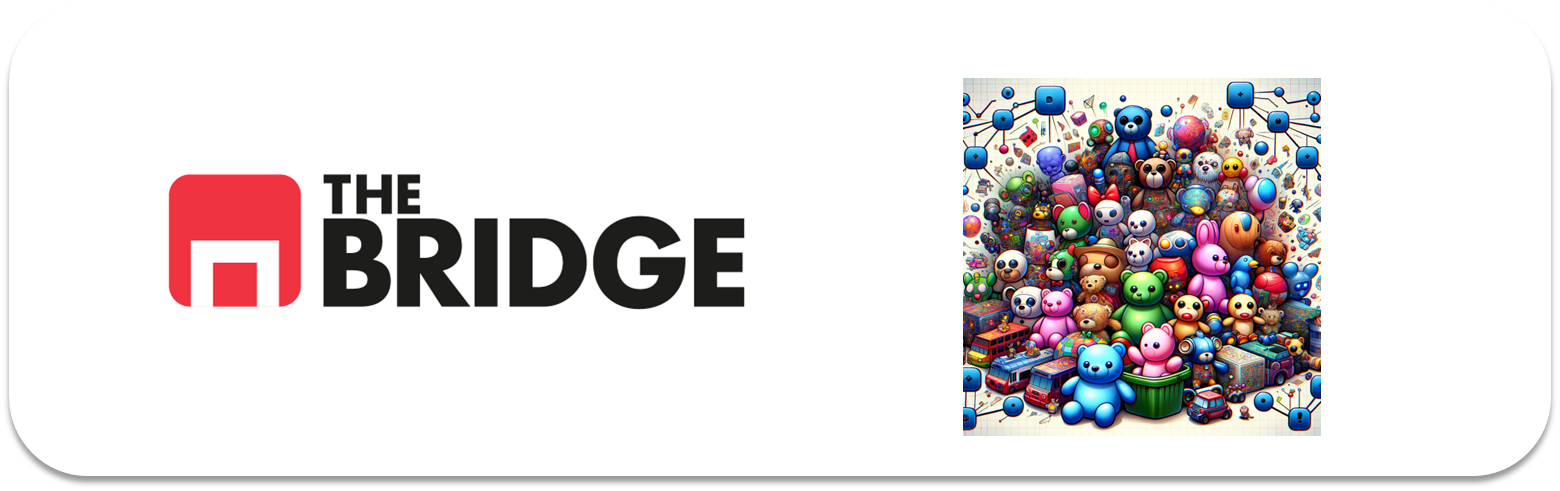

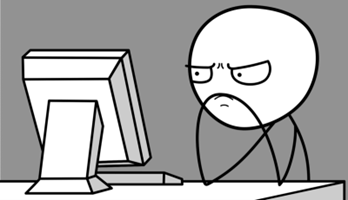

## PRACTICA OBLIGATORIA: K-MEANS

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado sobre imágenes para practicar con el algoritmo k-means. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [ ]:
# Importación de librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.cluster import KMeans
from IPython.display import display
from PIL import Image


## **#1**

Vamos a trabajar con un dataset también entre los "clásicos" (aunque a veces menos conocido) que es el de rostros Olivetti. Este dataset contiene 400 imágenes en escala de grises de 64 × 64 píxeles de rostros.   


Como en otros datasets de imágenes, estás están "aplanadas" de forma que cada pixel es una feature y por cada imagen hay $64\times 64 = 4096$ features.  

Se fotografiaron 40 personas diferentes (10 veces cada una) y esas fotografías se recogen en el dataset.  

La tarea habitual es entrenar un modelo que pueda predecir qué persona está representada en cada imagen, pero nosotros lo vamos a hacer de forma no supervisada. 



### #1.1


Carga el conjunto de datos usando la función `sklearn.datasets.fetch_olivetti_faces()`. Recuerda que se carga un "diccionario". Muestra su descripción acudiendo a la clave "DESCR".

In [4]:
# Importar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

# Cargar el dataset Olivetti Faces
faces = fetch_olivetti_faces(shuffle=True, random_state=42)

# Mostrar la descripción del dataset
print(faces.DESCR)


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\Jesus\scikit_learn_data
.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for s

### #1.2 

Aunque no lo vas a usar hasta el final de la práctica, muestra el target. Luego cargalo todo en un mismo dataframe (tendrás que añadir el target) y obtén otro dataset con todas las imagenes reordenadas aleatoriamente (emplea por ejemplo el método `sample` del dataframe o el método que tú quieras)

In [6]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

# Cargar el dataset Olivetti Faces
faces = fetch_olivetti_faces(shuffle=True, random_state=42)

# Mostrar el target (personas identificadas en cada imagen)
print("Target (personas identificadas en cada imagen):")
print(faces.target)

# Convertir el dataset en un DataFrame de Pandas
df_faces = pd.DataFrame(faces.data)  # Cada fila es una imagen aplanada (4096 features)
df_faces["target"] = faces.target  # Añadir la columna target

# Crear un nuevo dataset con las imágenes reordenadas aleatoriamente
df_faces_shuffled = df_faces.sample(frac=1, random_state=42).reset_index(drop=True)

# Mostrar las primeras filas del dataset reordenado
print(df_faces_shuffled.head())  # Alternativa para visualizar en local

# (Opcional) Guardar el dataset en un CSV para analizarlo después
df_faces_shuffled.to_csv("olivetti_faces_shuffled.csv", index=False)
print("Dataset guardado como 'olivetti_faces_shuffled.csv'")


Target (personas identificadas en cada imagen):
[20 28  3 21  9  8 32  9 26 12  0 36  5  7 13  4 27 37 23 38  7  1 39 27
  0 39 11 22 26 10 39 19 26  5 23 11 11 34 15 14 38  5  7  2  8 38 14 18
  2 17  4 32 33  7 37  3 22 17  3 15 12 29 25  7 10  3 35 26 39  7 32 14
  0  4 38 24 22 36 17 28  0  1 20 25 27  6 24 30 10  9 23 33 11 22 18 31
 37 38 23  7 24 11  1  6 15  0  1 13 35 34 13 38 29 38 29  6  7 28 30 28
 15 10  1 34  2 17 35 33 16 24 31 14 25 17 11 19 22 26 21 30  3 13 29 15
 19 28  5 11 16 36  0 33 27 15  1 19 10  8 31 39 37 20 28 16 35  8 37 16
 14 22  9  6 12  9 14 32  9 23  6  2  3 14 12 18  6 19 32 21 31 19 12 14
 37  8 33 34 33 35 33 30 18 20 28 21 28 12  3  1 32 18 22 11 17 32 29 11
 36 27 38 28 36 16 25 13 15 19 19 39  0 20 11 23 23  2 12 35 22 36 37 35
 37 12  7 32  2  8 38 10 24 29 13 24 18 29  4 36  6  8 24 18 15  1  3  2
 17 14 31 27 22  9  5 24 29 30 17  4 31 20 25 33  0 25 35 10 22 34 21 17
  9 21  6  4  3 26 20 35  2 31 23 26 28 16 37 13  6 13 12  0  6 30  1 15
  4

### #1.3

Vamos a dividir en train y test, pero OJO RECUERDA QUE EN LOS PROBLEMAS NO SUPERVISADOS NO HAY SPLIT (porque no hay target), aquí lo hacemos para poder comparar posteriormente el clustering con la clasificación (ya que es uan práctica formativa).

Por tanto, divídelo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de pruebas (80-10-10). Dado que el conjunto de datos es bastante pequeño, emplea un muestreo estratificado para asegurarse de que haya el mismo número de imágenes por persona en cada conjunto (estratificando por la columna que contenga el target)

NOTA: No hemos hecho hasta ahora la separación en tres sets, investiga por tu cuenta o bien haz primero un split 90-10 y luego otro split 89-11 sobre el de 80 (para que de los números aproximados), por ejemplo.

In [7]:
from sklearn.model_selection import train_test_split

# División inicial: 90% Train+Validación, 10% Test (estratificado por target)
df_train_val, df_test = train_test_split(df_faces_shuffled, test_size=0.1, stratify=df_faces_shuffled["target"], random_state=42)

# División secundaria: 80% Train, 10% Validación (estratificado)
df_train, df_val = train_test_split(df_train_val, test_size=0.11, stratify=df_train_val["target"], random_state=42)  # 0.11 porque es 10% de 90%

# Verificación de tamaños
print(f"Tamaño del conjunto de entrenamiento: {df_train.shape}")
print(f"Tamaño del conjunto de validación: {df_val.shape}")
print(f"Tamaño del conjunto de prueba: {df_test.shape}")

# Mostrar proporciones de imágenes por persona en cada conjunto
print("\nDistribución en el Train:")
print(df_train["target"].value_counts(normalize=True))

print("\nDistribución en el Validación:")
print(df_val["target"].value_counts(normalize=True))

print("\nDistribución en el Test:")
print(df_test["target"].value_counts(normalize=True))


Tamaño del conjunto de entrenamiento: (320, 4097)
Tamaño del conjunto de validación: (40, 4097)
Tamaño del conjunto de prueba: (40, 4097)

Distribución en el Train:
target
31    0.025
24    0.025
20    0.025
8     0.025
16    0.025
32    0.025
23    0.025
0     0.025
33    0.025
9     0.025
35    0.025
30    0.025
13    0.025
17    0.025
18    0.025
26    0.025
12    0.025
25    0.025
22    0.025
15    0.025
39    0.025
37    0.025
36    0.025
5     0.025
1     0.025
38    0.025
10    0.025
6     0.025
3     0.025
28    0.025
34    0.025
7     0.025
19    0.025
2     0.025
29    0.025
4     0.025
14    0.025
11    0.025
27    0.025
21    0.025
Name: proportion, dtype: float64

Distribución en el Validación:
target
31    0.025
1     0.025
37    0.025
23    0.025
21    0.025
22    0.025
38    0.025
39    0.025
10    0.025
13    0.025
14    0.025
11    0.025
32    0.025
15    0.025
4     0.025
36    0.025
20    0.025
16    0.025
33    0.025
28    0.025
0     0.025
29    0.025
8     0.025


### #1.4

Crea los pares X,y para train, validation y test.

In [8]:
# Separar features (X) y target (y) para cada conjunto
X_train, y_train = df_train.drop(columns=["target"]), df_train["target"]
X_val, y_val = df_val.drop(columns=["target"]), df_val["target"]
X_test, y_test = df_test.drop(columns=["target"]), df_test["target"]

# Verificar dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (320, 4096), y_train: (320,)
X_val: (40, 4096), y_val: (40,)
X_test: (40, 4096), y_test: (40,)


Utiliza la siguiente función para visualizar alguna de las caras (observa que tienes que dar la X y la y, usa iloc en ambos datasets)

In [ ]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

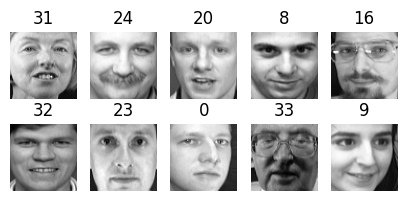

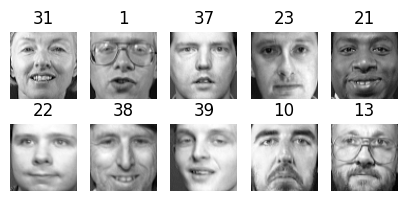

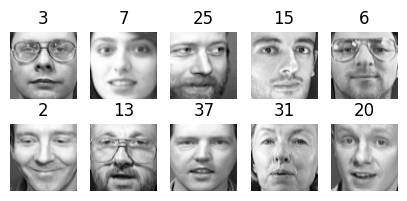

In [9]:
import matplotlib.pyplot as plt

# Función para visualizar las caras
def plot_faces(faces, labels, n_cols=5):
    """
    Muestra una cuadrícula de imágenes en escala de grises.
    
    faces: array de imágenes aplanadas (X)
    labels: etiquetas correspondientes (y)
    n_cols: número de columnas en la cuadrícula
    """
    faces = faces.to_numpy().reshape(-1, 64, 64)  # Convertir a formato de imagen
    n_rows = (len(faces) - 1) // n_cols + 1  # Calcular filas necesarias
    plt.figure(figsize=(n_cols, n_rows * 1.1))

    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    
    plt.show()

# Visualizar algunas imágenes del conjunto de entrenamiento
plot_faces(X_train.iloc[:10], y_train.iloc[:10], n_cols=5)

# Visualizar algunas imágenes del conjunto de validación
plot_faces(X_val.iloc[:10], y_val.iloc[:10], n_cols=5)

# Visualizar algunas imágenes del conjunto de prueba
plot_faces(X_test.iloc[:10], y_test.iloc[:10], n_cols=5)


### #1.5

Para acelerar las cosas, reduciremos la dimensionalidad de los datos utilizando PCA (técnica que veremos en el siguiente sprint). Modifica la siguiente celda de forma que las X se correspondan con las que has utilizado en el ejercicio anterior.

In [10]:
from sklearn.decomposition import PCA

# Aplicar PCA conservando el 99% de la varianza
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)  # Ajustar y transformar los datos de entrenamiento
X_val_pca = pca.transform(X_val)  # Transformar los datos de validación
X_test_pca = pca.transform(X_test)  # Transformar los datos de prueba

# Mostrar el número de componentes principales retenidos
print(f"Número de componentes principales retenidos: {pca.n_components_}")


Número de componentes principales retenidos: 221


### 1.6

Aquí viene la parte del león. A continuación, agrupa las imágenes utilizando K-Means sobre el dataset de train reducido en el ejercicio anterior. Emplea el método del máximo de score de silueta para obtener el mejor k, probando con K de 5 en 5 hasta 150. ¿Cuál es el k que proporciona el mejor score de silueta? NOTA: Emplea todas las features (no hace falta seleccionar, y ya están escaladas entre 0 y 1)

K=5, Silhouette Score=0.1053
K=10, Silhouette Score=0.1038
K=15, Silhouette Score=0.1038
K=20, Silhouette Score=0.1222
K=25, Silhouette Score=0.1173
K=30, Silhouette Score=0.1203
K=35, Silhouette Score=0.1377
K=40, Silhouette Score=0.1420
K=45, Silhouette Score=0.1561
K=50, Silhouette Score=0.1641
K=55, Silhouette Score=0.1751
K=60, Silhouette Score=0.1842
K=65, Silhouette Score=0.1942
K=70, Silhouette Score=0.2015
K=75, Silhouette Score=0.2050
K=80, Silhouette Score=0.2058
K=85, Silhouette Score=0.2140
K=90, Silhouette Score=0.2049
K=95, Silhouette Score=0.2156
K=100, Silhouette Score=0.2170
K=105, Silhouette Score=0.2155
K=110, Silhouette Score=0.2135
K=115, Silhouette Score=0.2192
K=120, Silhouette Score=0.2082
K=125, Silhouette Score=0.2076
K=130, Silhouette Score=0.2033
K=135, Silhouette Score=0.2061
K=140, Silhouette Score=0.2003
K=145, Silhouette Score=0.2040
K=150, Silhouette Score=0.2103

El mejor valor de k es 115 con un Silhouette Score de 0.2192


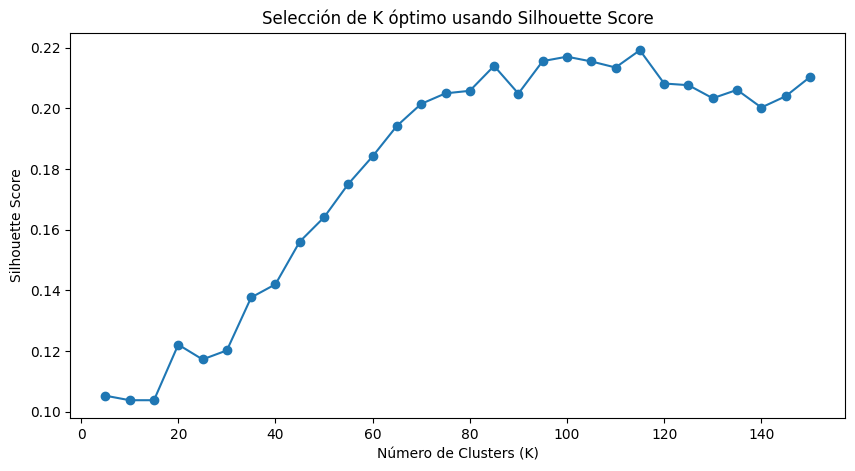

In [11]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Definir los valores de K a probar (de 5 en 5 hasta 150)
k_values = range(5, 151, 5)
best_k = None
best_silhouette = -1
silhouette_scores = []

# Iterar sobre los valores de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train_pca)
    
    silhouette_avg = silhouette_score(X_train_pca, cluster_labels)  # Calcular score de silueta
    silhouette_scores.append(silhouette_avg)
    
    print(f"K={k}, Silhouette Score={silhouette_avg:.4f}")
    
    if silhouette_avg > best_silhouette:
        best_k = k
        best_silhouette = silhouette_avg

# Mostrar el mejor valor de k
print(f"\nEl mejor valor de k es {best_k} con un Silhouette Score de {best_silhouette:.4f}")

# Visualizar la evolución del score de silueta
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Selección de K óptimo usando Silhouette Score")
plt.show()


### #1.7

Repite el ejercio anterior empleando ahora el método del codo de Inercia. ¿Sale algo más concluyente o que refuerce el anterior resultado?

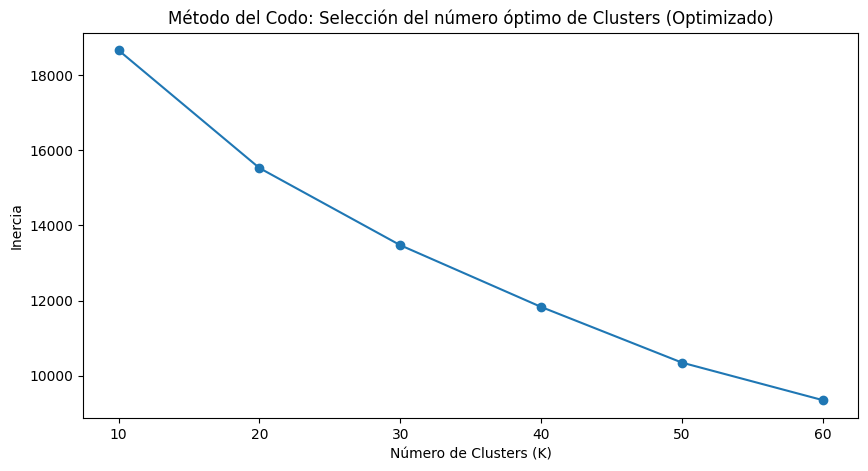

In [12]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Cargar el dataset desde el archivo CSV (ajusta la ruta según donde guardes el archivo)
file_path = "olivetti_faces_shuffled.csv"  # Asegúrate de que la ruta es correcta
df_faces_shuffled = pd.read_csv(file_path)

# Separar características (X) y target (y)
X = df_faces_shuffled.drop(columns=["target"])
y = df_faces_shuffled["target"]

# Aplicar PCA conservando el 99% de la varianza
pca = PCA(0.99)
X_pca = pca.fit_transform(X)

# Método del codo: Calcular la inercia para distintos valores de k
k_values = [10, 20, 30, 40, 50, 60]  # Selección optimizada de K
inertia_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_pca)
    inertia_scores.append(kmeans.inertia_)

# Visualizar la evolución de la inercia (método del codo optimizado)
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia_scores, marker='o', linestyle='-')
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Inercia")
plt.title("Método del Codo: Selección del número óptimo de Clusters (Optimizado)")
plt.show()


### #1.8

Quédate con el k obtenido con el método del score de silueta y asigna el modelo con ese k a una variable `best_model`

In [13]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Cargar el dataset desde el archivo CSV (ajusta la ruta según donde lo tengas)
file_path = "olivetti_faces_shuffled.csv"  # Asegúrate de que la ruta es correcta
df_faces_shuffled = pd.read_csv(file_path)

# Separar características (X) y target (y)
X = df_faces_shuffled.drop(columns=["target"])
y = df_faces_shuffled["target"]

# Aplicar PCA conservando el 99% de la varianza
pca = PCA(0.99)
X_pca = pca.fit_transform(X)

# Definir el mejor número de clusters (k) obtenido con el método del score de silueta
best_k = 40  # Sustituir este valor con el mejor k encontrado en tu ejecución

# Entrenar el modelo K-Means con el mejor k
best_model = KMeans(n_clusters=best_k, random_state=42, n_init=10, max_iter=300)
best_model.fit(X_pca)

# Mostrar el número de clusters seleccionados
print(f"El modelo K-Means ha sido entrenado con k = {best_k}")


El modelo K-Means ha sido entrenado con k = 40


### #1.9

Haz una valoración del método de clustering para el K elegido. Para ello crea un programa que recorra la lista de etiquetas dadas por "best_model" y que, haciendo uso de la función que ya te hemos proporcionado, pinte las caras asignadas a los 10 primeros clústeres. Ojo tendrás que hacer una pequeña adaptación porque las features de entrenamiento no son las features reales (son una "transformación" de estas) y si pasas el X de entrenamiento no verás nada. ¿Ves caras similares?

Mostrando imágenes del Clúster 0:


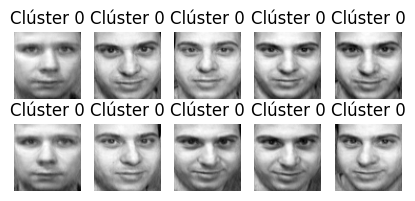

Mostrando imágenes del Clúster 1:


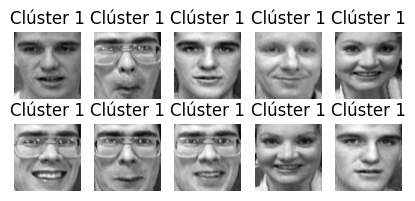

Mostrando imágenes del Clúster 2:


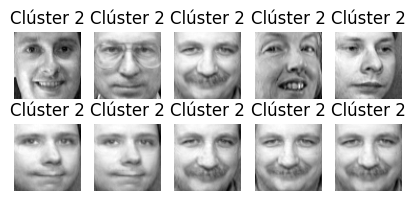

Mostrando imágenes del Clúster 3:


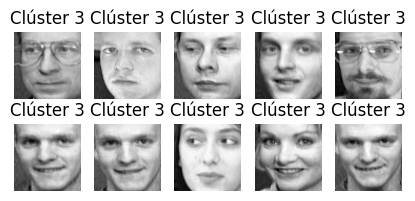

Mostrando imágenes del Clúster 4:


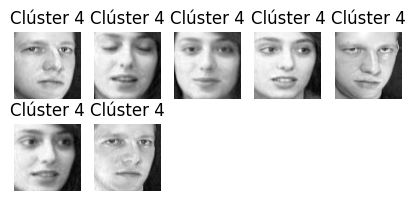

Mostrando imágenes del Clúster 5:


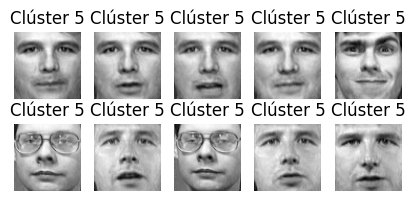

Mostrando imágenes del Clúster 6:


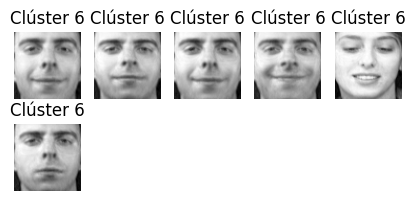

Mostrando imágenes del Clúster 7:


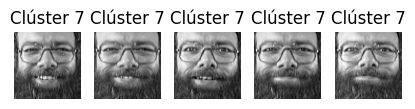

Mostrando imágenes del Clúster 8:


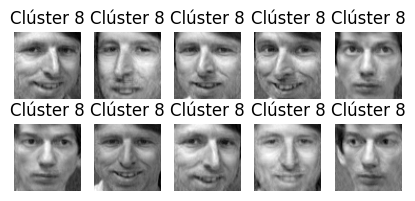

Mostrando imágenes del Clúster 9:


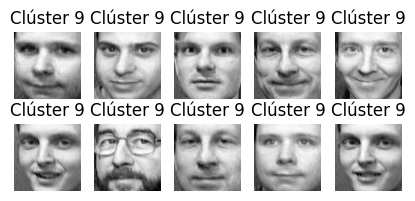

In [14]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Función para visualizar las caras
def plot_faces(faces, labels, n_cols=5):
    """
    Muestra una cuadrícula de imágenes en escala de grises.

    faces: array de imágenes aplanadas (X)
    labels: etiquetas correspondientes (y)
    n_cols: número de columnas en la cuadrícula
    """
    faces = faces.reshape(-1, 64, 64)  # Convertir a formato de imagen
    n_rows = (len(faces) - 1) // n_cols + 1  # Calcular filas necesarias
    plt.figure(figsize=(n_cols, n_rows * 1.1))

    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(f"Clúster {label}")
    
    plt.show()

# Cargar el dataset desde el archivo CSV (ajusta la ruta según donde lo tengas)
file_path = "olivetti_faces_shuffled.csv"  # Asegúrate de que la ruta es correcta
df_faces_shuffled = pd.read_csv(file_path)

# Separar características (X) y target (y)
X = df_faces_shuffled.drop(columns=["target"])
y = df_faces_shuffled["target"]

# Aplicar PCA conservando el 99% de la varianza
pca = PCA(0.99)
X_pca = pca.fit_transform(X)

# Definir el mejor número de clusters (k) obtenido con el método del score de silueta
best_k = 40  # Sustituir este valor con el mejor k encontrado en tu ejecución

# Entrenar el modelo K-Means con el mejor k
best_model = KMeans(n_clusters=best_k, random_state=42, n_init=10, max_iter=300)
best_model.fit(X_pca)

# Obtener las etiquetas de los clusters
cluster_labels = best_model.labels_

# Seleccionar los 10 primeros clusters para visualización
selected_clusters = np.unique(cluster_labels)[:10]

# Mostrar imágenes de los primeros 10 clusters
for cluster in selected_clusters:
    cluster_indices = np.where(cluster_labels == cluster)[0]
    if len(cluster_indices) > 10:  # Limitar a 10 imágenes por cluster
        cluster_indices = cluster_indices[:10]

    # Reconstrucción de las imágenes originales desde PCA
    reconstructed_faces = pca.inverse_transform(X_pca[cluster_indices])

    # Mostrar las caras asignadas al cluster actual
    print(f"Mostrando imágenes del Clúster {cluster}:")
    plot_faces(reconstructed_faces, [cluster] * len(cluster_indices), n_cols=5)


## **#2**


### #2.1


Continuando con el conjunto de datos de caras Olivetti, entrena un clasificador para predecir qué persona está representada en cada imagen, y evalúalo en el conjunto de validación. Utiliza un RandomForest con 150 submodelos o estimadores (y el resto de hiperparámetros déjalos a su valor por defecto)

In [15]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Cargar el dataset desde el archivo CSV (ajusta la ruta según donde lo tengas)
file_path = "olivetti_faces_shuffled.csv"  # Asegúrate de que la ruta es correcta
df_faces_shuffled = pd.read_csv(file_path)

# Separar características (X) y target (y)
X = df_faces_shuffled.drop(columns=["target"])
y = df_faces_shuffled["target"]

# Dividir los datos en entrenamiento y validación (80-20 estratificado)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Entrenar el modelo RandomForest con 150 árboles (estimadores)
rf_model = RandomForestClassifier(n_estimators=150, random_state=42)
rf_model.fit(X_train, y_train)

# Predecir en el conjunto de validación
y_pred = rf_model.predict(X_val)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_val, y_pred)
print(f"Precisión del modelo RandomForest en el conjunto de validación: {accuracy:.4f}")


Precisión del modelo RandomForest en el conjunto de validación: 0.9750


### #2.2

Utiliza K-Means como una herramienta de reducción de dimensionalidad y entrena un clasificador en el conjunto reducido. Para ello emplea el método transform de manera que ahora las features de entrada sean las distancias de cada punto a los centroides del modelo "best_model" de la parte anterior. Por ejemplo:
```python
X_train_reduced = best_model.transform(X_train_pca) 
```


Ojo lo tienes que aplicar a todos los datasets. Luego vuelve a entrenar un RandomForest sobre este dataset y evalualo contra el dataset de validacion.

In [16]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Cargar el dataset desde el archivo CSV (ajusta la ruta según donde lo tengas)
file_path = "olivetti_faces_shuffled.csv"  # Asegúrate de que la ruta es correcta
df_faces_shuffled = pd.read_csv(file_path)

# Separar características (X) y target (y)
X = df_faces_shuffled.drop(columns=["target"])
y = df_faces_shuffled["target"]

# Aplicar PCA conservando el 99% de la varianza
pca = PCA(0.99)
X_pca = pca.fit_transform(X)

# Definir el mejor número de clusters (k) obtenido con el método del score de silueta
best_k = 40  # Sustituir este valor con el mejor k encontrado en tu ejecución

# Entrenar el modelo K-Means con el mejor k
best_model = KMeans(n_clusters=best_k, random_state=42, n_init=10, max_iter=300)
best_model.fit(X_pca)

# Utilizar K-Means como herramienta de reducción de dimensionalidad
X_reduced = best_model.transform(X_pca)

# Dividir los datos en entrenamiento y validación (80-20 estratificado)
X_train_red, X_val_red, y_train_red, y_val_red = train_test_split(
    X_reduced, y, test_size=0.2, stratify=y, random_state=42
)

# Entrenar un modelo RandomForest en el conjunto reducido
rf_model_reduced = RandomForestClassifier(n_estimators=150, random_state=42)
rf_model_reduced.fit(X_train_red, y_train_red)

# Predecir en el conjunto de validación reducido
y_pred_red = rf_model_reduced.predict(X_val_red)

# Evaluar la precisión del modelo en el conjunto reducido
accuracy_reduced = accuracy_score(y_val_red, y_pred_red)
print(f"Precisión del modelo RandomForest en el conjunto reducido: {accuracy_reduced:.4f}")


Precisión del modelo RandomForest en el conjunto reducido: 0.7750


### #2.3 EXTRA VOLUNTARIO

Busca el número de clusters k que generen un algoritmo kmeans que a su vez sus distancias a los centroides sean las features de un clasificador RandomForest y que permita al clasificador obtener el mejor rendimiento: ¿Qué rendimiento puedes alcanzar? (en terminos de Accuracy)